In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import tqdm
import ultralytics
import glob
import re

In [2]:
CLASS_NAMES = ['aeroplane' ,'bicycle' ,'bird' ,'boat' ,'bottle' ,
               'bus' ,'car' ,'cat' ,'chair' ,'cow' ,'diningtable' ,
               'dog' ,'horse' ,'motorbike' ,'person' ,'pottedplant' ,
               'sheep' ,'sofa' ,'train' ,'tvmonitor']

COLORS = [
    [255, 0, 0],        # Красный
    [0, 255, 0],        # Зеленый
    [0, 0, 255],        # Синий
    [255, 255, 0],      # Желтый
    [255, 0, 255],      # Фиолетовый
    [0, 255, 255],      # Бирюзовый
    [128, 0, 0],        # Темно-красный
    [0, 128, 0],        # Темно-зеленый
    [0, 0, 128],        # Темно-синий
    [128, 128, 0],      # Темно-желтый
    [128, 0, 128],      # Темно-фиолетовый
    [0, 128, 128],      # Темно-бирюзовый
    [67, 67, 67],    # Серый
    [255, 165, 0],      # Оранжевый
    [67, 0, 130],    # Розовый
    [139, 69, 19],      # Коричневый
    [169, 169, 169],    # Темно-серый
    [12, 138, 14],    # Светло-зеленый
    [255, 20, 147],     # Гелиотроп
    [255, 99, 71]       # Темно-красный
] #, dtype=np.uint8


In [2]:
def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df

In [3]:
def get_mAP(path):
    exps = os.listdir(path)
    exps = [x for x in exps if re.match('^exp_\d$', x) is not None]
    exps = sorted(exps, key=lambda x: int(re.findall('\d+',x)[0]))
    results =[]
    for exp in exps:
        full_path = f'{path}/{exp}/train/results.csv'
        data = prepare_df(full_path)
        res = [data['metrics/mAP50(B)'].values, data['metrics/mAP50-95(B)'].values]
        results.append(res)


    return np.array(results)
get_mAP('../runs/split_exp/orig/nano/1000').shape

# [num_of_exps, map, num_epochs]

(2, 2, 30)

## mAP by epochs

In [4]:
def get_mean_by_epoch(data):
    # data = np.array(data)
    map50 = data[:,0,:].mean(axis=0)
    std50 = data[:,0,:].std(axis=0)
    map5095 = data[:,1,:].mean(axis=0)
    std5095 = data[:,1,:].std(axis=0)
    return np.stack((map50, std50, map5095, std5095), axis=-1)

# [num_of_epochs, map] 

In [5]:
def plot_map_by_epoch(data, title, y_label, fig = None, ax=None, y_lim=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

    # epochs = np.array([20, 40, 60, 80, 100])
    colors = [
        "#b30000",
        "#4421af"
    ]
    epochs = np.arange(1,31)

    mean50 = data[:, 0][:len(epochs)]
    std50 = data[:, 1][:len(epochs)]
    mean5095 = data[:, 2][:len(epochs)]
    std5095 = data[:, 3][:len(epochs)]

    #### mAP 50
    ax.plot( epochs, mean50, label = 'mAP 50', color=colors[0])
    ax.fill_between(epochs, mean50 - std50, mean50 + std50, alpha=0.2, color=colors[0])  # Adding shaded area for standard deviation

    #### mAP 50-95
    ax.plot( epochs, mean5095, label = 'mAP 50-95', color=colors[1])
    ax.fill_between(epochs, mean5095 - std5095, mean5095 + std5095, alpha=0.2, color=colors[1])  # Adding shaded area for standard deviation

    if y_lim is not None:
        ax.set_ylim(*y_lim)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.legend(fontsize=14, loc='lower right')
    ax.grid(which="major", linewidth=1)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(title, fontsize=18, pad = 20)

    return fig, ax


YOLO nano model trained on 100 objects of the original dataset.png
YOLO nano model trained on 200 objects of the original dataset.png
YOLO nano model trained on 500 objects of the original dataset.png
YOLO nano model trained on 1000 objects of the original dataset.png
YOLO nano model trained on 2501 objects of the original dataset.png
YOLO small model trained on 100 objects of the original dataset.png
YOLO small model trained on 200 objects of the original dataset.png
YOLO small model trained on 500 objects of the original dataset.png
YOLO small model trained on 1000 objects of the original dataset.png
YOLO small model trained on 2501 objects of the original dataset.png
YOLO nano model trained on 100 objects of the pseudo labeled dataset.png
YOLO nano model trained on 200 objects of the pseudo labeled dataset.png
YOLO nano model trained on 500 objects of the pseudo labeled dataset.png
YOLO nano model trained on 1000 objects of the pseudo labeled dataset.png
YOLO nano model trained on 2

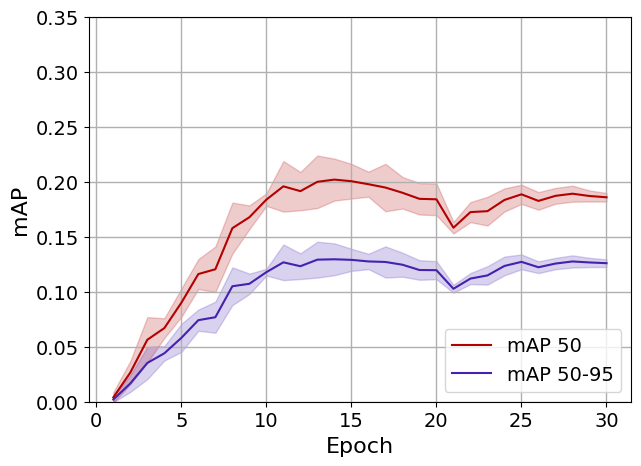

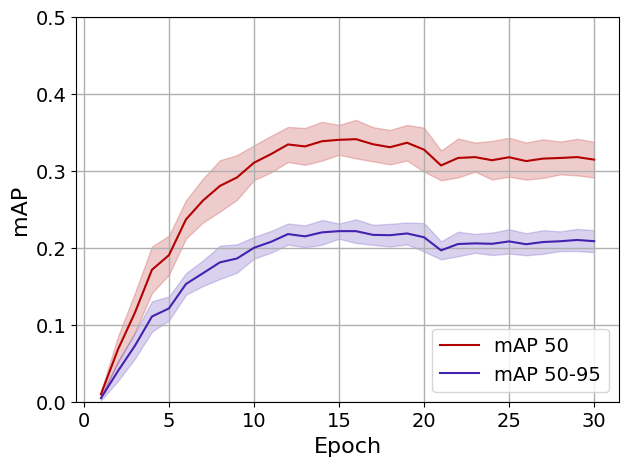

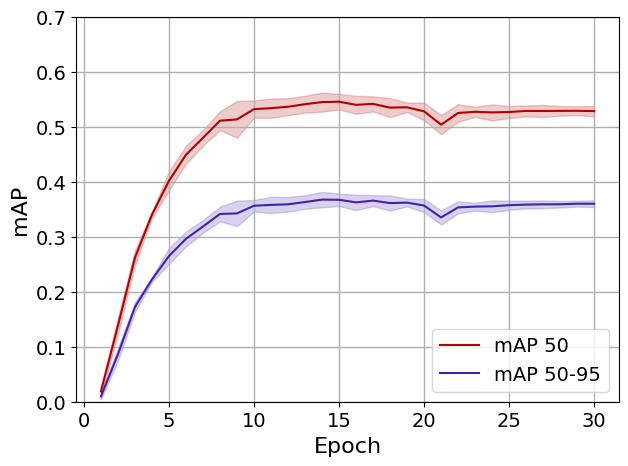

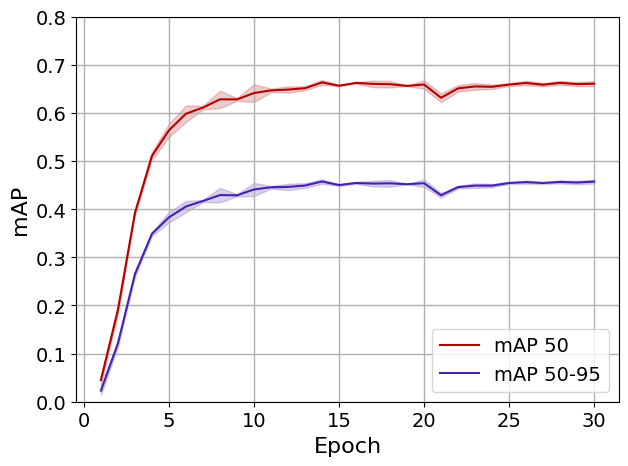

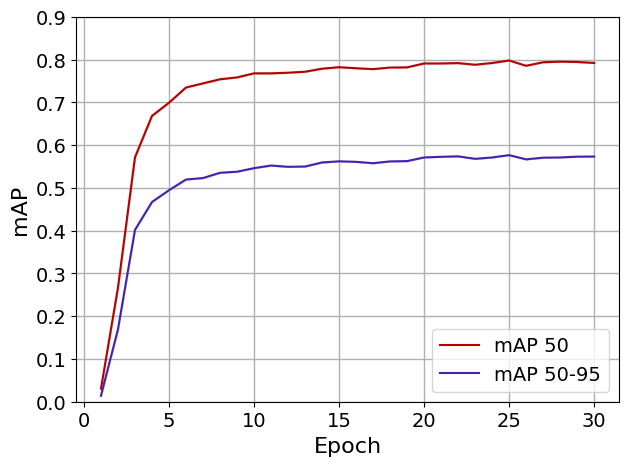

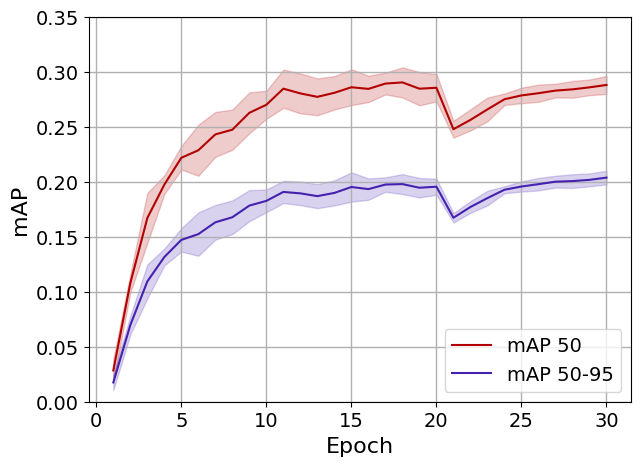

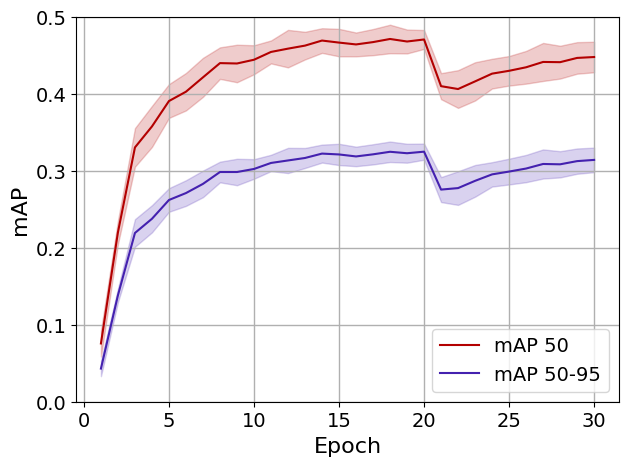

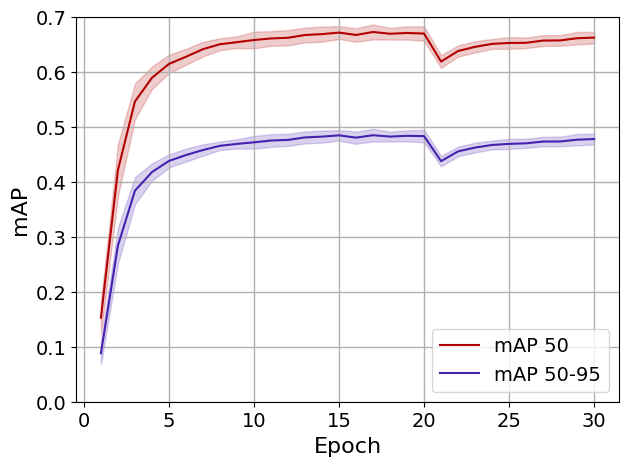

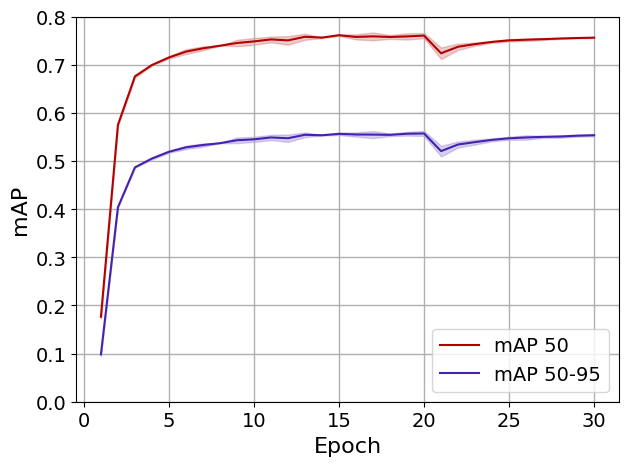

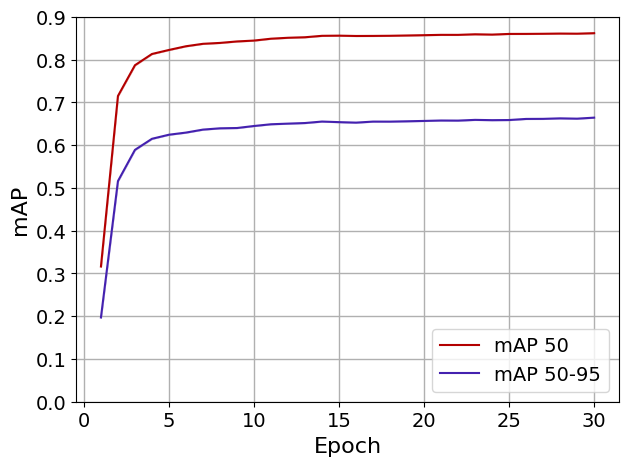

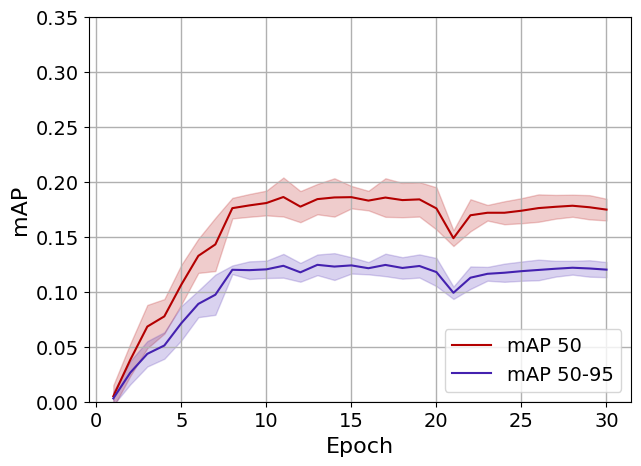

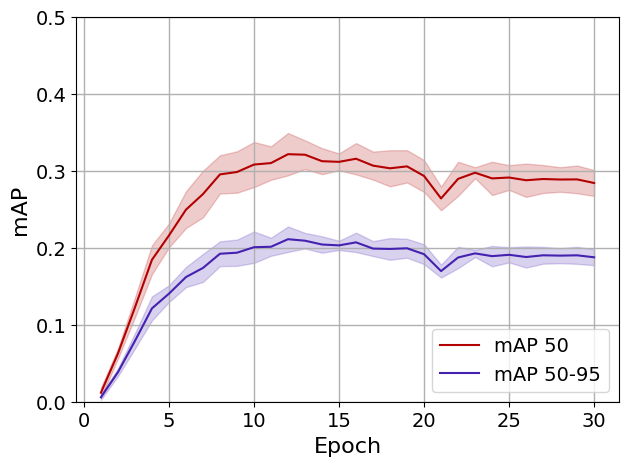

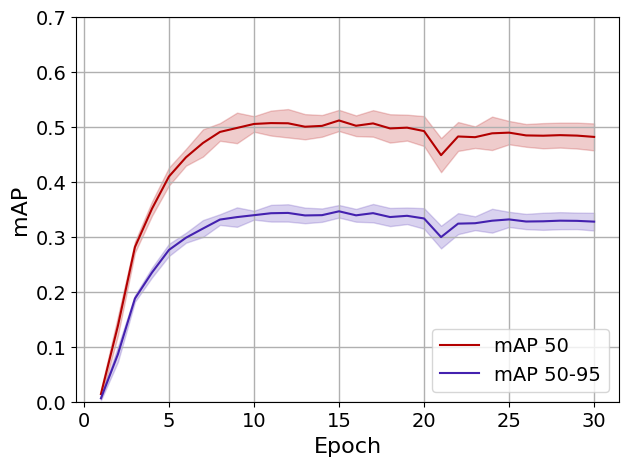

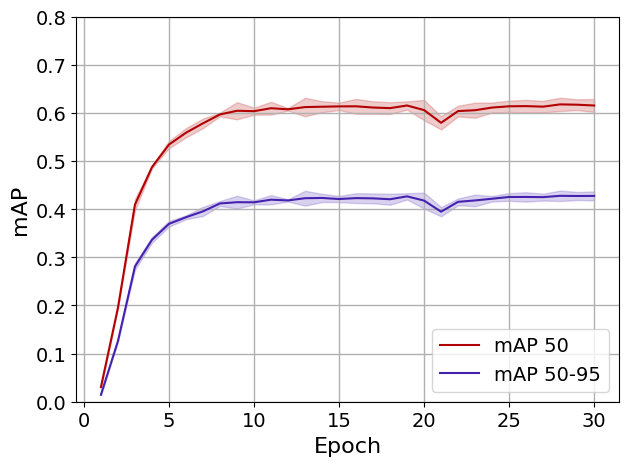

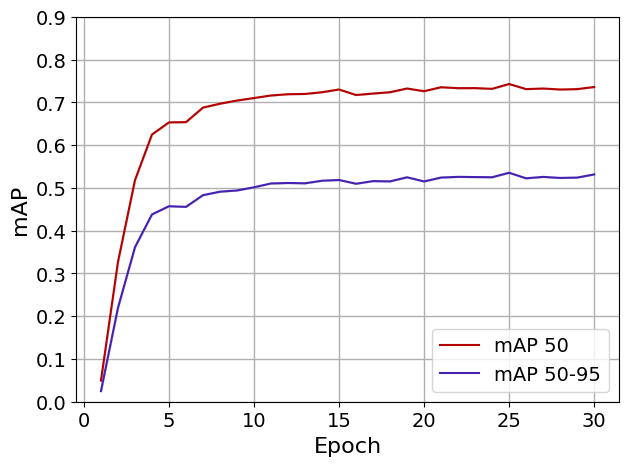

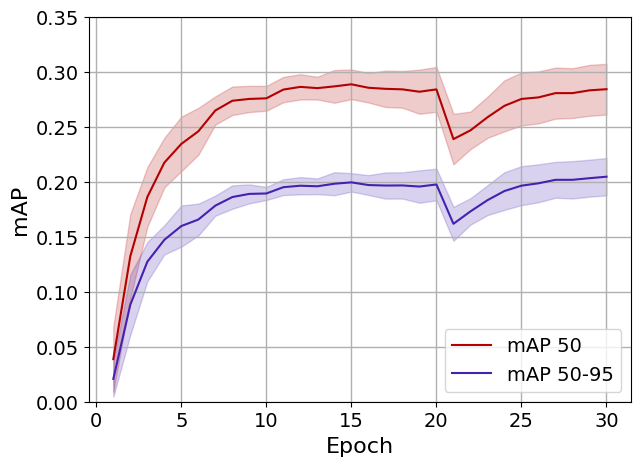

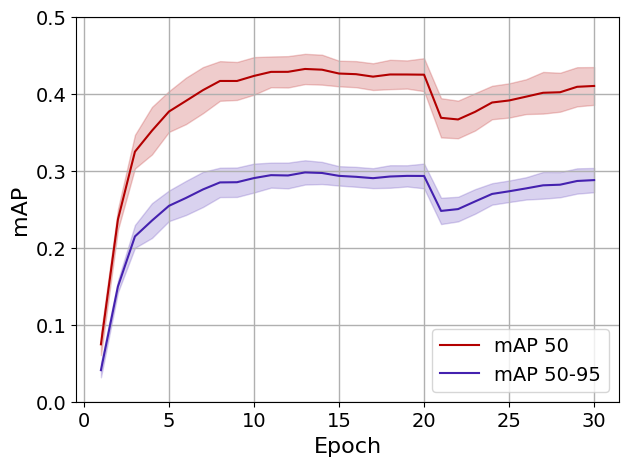

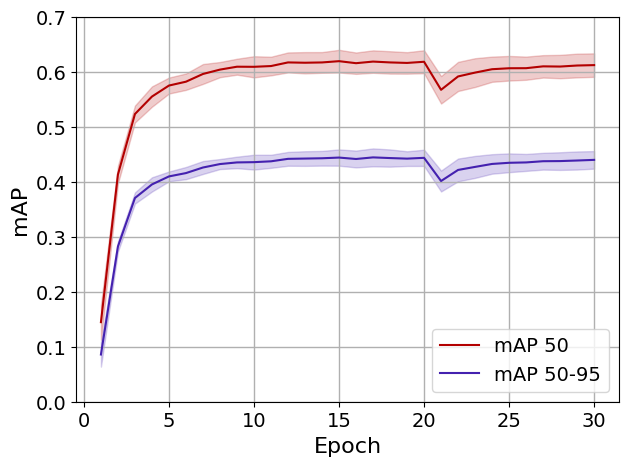

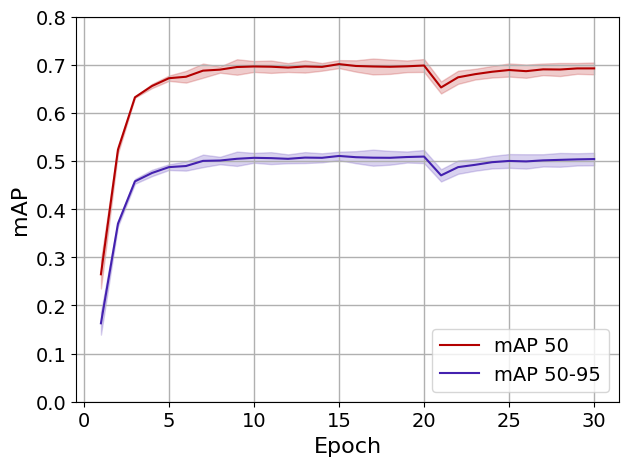

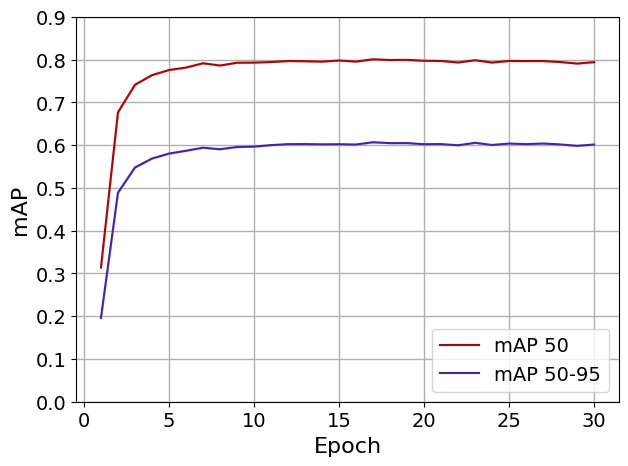

In [6]:
save_dir = 'outputs/partitial_by_epochs'
os.makedirs(save_dir)
dataset_names = ['original dataset', 'pseudo labeled dataset']
datasets = ['orig', 'GD_train_val']
models = ['nano', 'small']
data_volumes = ['100','200','500','1000','2501']
y_lims = [(0,0.35), (0,0.5), (0,0.7), (0,0.8), (0,0.9)]

for dataset_path, dataset_name in zip(datasets, dataset_names):
    for model_path, model_name in zip(models, models):
        for d_volume_path, d_volume_name, y_lim in zip(data_volumes, data_volumes, y_lims):
            data = get_mAP(f'../runs/split_exp/{dataset_path}/{model_path}/{d_volume_path}')
            fig, _ = plot_map_by_epoch(get_mean_by_epoch(data), title='', y_label='mAP', ax=None, y_lim=y_lim)
            file_name = f'YOLO {model_name} model trained on {d_volume_name} objects of the {dataset_name}.png'
            print(file_name)
            fig.savefig(f'{save_dir}/{file_name}')

In [7]:
def plot_map50_by_epoch(data1, data2, title, label1, label2, fig = None, ax=None, y_lim=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

    # epochs = np.array([20, 40, 60, 80, 100])
    epochs = np.arange(1,31)
    data1 = data1[:len(epochs),:]
    data2 = data2[:len(epochs),:]

    colors = [
        "#b30000",
        "#4421af"
    ]
    
    for data, label, color in zip([data1, data2],[label1, label2], colors):
        #### mAP 50
        ax.plot( epochs, data[:, 0], label = label, color=color)
        ax.fill_between(epochs, data[:, 0] - data[:, 1], data[:, 0] + data[:, 1], alpha=0.2, color=color)  # Adding shaded area for standard deviation



    if y_lim is not None:
        ax.set_ylim(*y_lim)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.legend(fontsize=14, loc='lower right')
    ax.grid(which="major", linewidth=1)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylabel('mAP 50', fontsize=16)
    ax.set_title(title, fontsize=18, pad = 20)

    return fig, ax


In [8]:
def plot_map5095_by_epoch(data1, data2, title, label1, label2, fig = None, ax=None, y_lim=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

    # epochs = np.array([20, 40, 60, 80, 100])
    epochs = np.arange(1,31)
    data1 = data1[:len(epochs),:]
    data2 = data2[:len(epochs),:]

    colors = [
        "#b30000",
        "#4421af"
    ]
    
    for data, label, color in zip([data1, data2],[label1, label2], colors):
        #### mAP 50-95
        ax.plot( epochs, data[:, 2], label = label, color=color)
        ax.fill_between(epochs, data[:, 2] - data[:, 3], data[:, 2] + data[:, 3], alpha=0.2, color=color)  # Adding shaded area for standard deviation



    if y_lim is not None:
        ax.set_ylim(*y_lim)
    ax.set_xlabel('Epoch', fontsize=16)
    ax.legend(fontsize=14, loc='lower right')
    ax.grid(which="major", linewidth=1)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylabel('mAP 50-95', fontsize=16)
    ax.set_title(title, fontsize=18, pad = 20)

    return fig, ax


mAP 50 YOLO nano model trained on 100 objects.png
mAP 50 YOLO nano model trained on 200 objects.png
mAP 50 YOLO nano model trained on 500 objects.png
mAP 50 YOLO nano model trained on 1000 objects.png
mAP 50 YOLO nano model trained on 2501 objects.png
mAP 50 YOLO small model trained on 100 objects.png
mAP 50 YOLO small model trained on 200 objects.png
mAP 50 YOLO small model trained on 500 objects.png
mAP 50 YOLO small model trained on 1000 objects.png
mAP 50 YOLO small model trained on 2501 objects.png
mAP 50-95 YOLO nano model trained on 100 objects.png
mAP 50-95 YOLO nano model trained on 200 objects.png
mAP 50-95 YOLO nano model trained on 500 objects.png
mAP 50-95 YOLO nano model trained on 1000 objects.png
mAP 50-95 YOLO nano model trained on 2501 objects.png
mAP 50-95 YOLO small model trained on 100 objects.png
mAP 50-95 YOLO small model trained on 200 objects.png
mAP 50-95 YOLO small model trained on 500 objects.png
mAP 50-95 YOLO small model trained on 1000 objects.png
mAP 50-

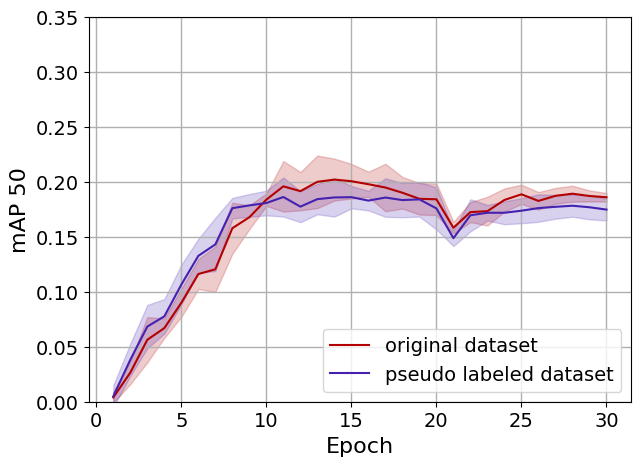

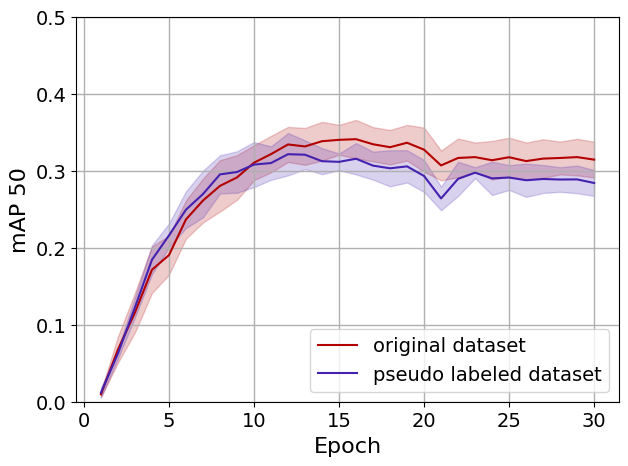

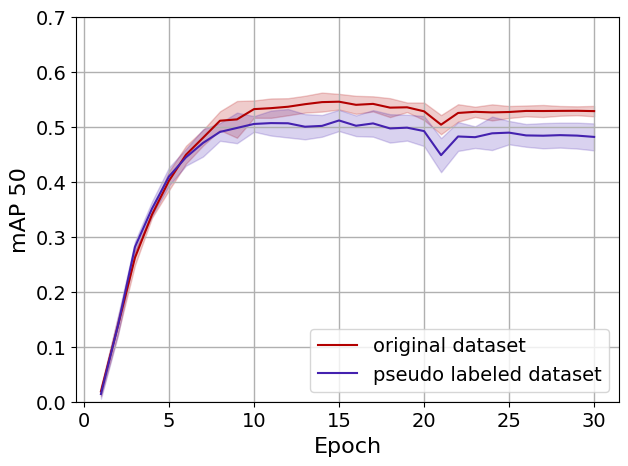

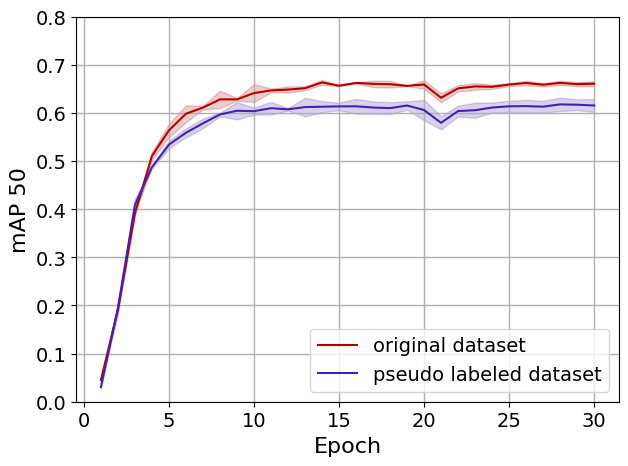

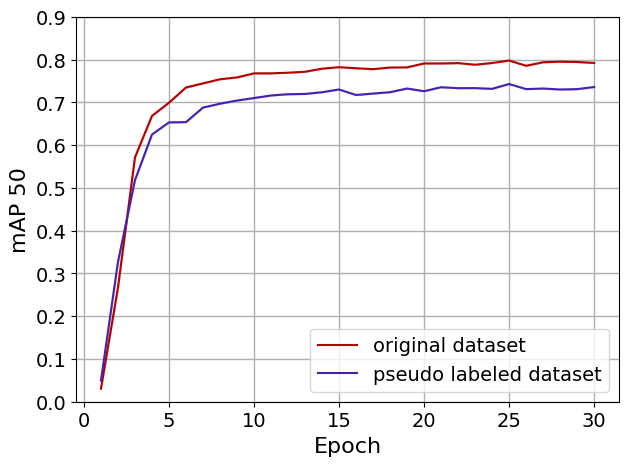

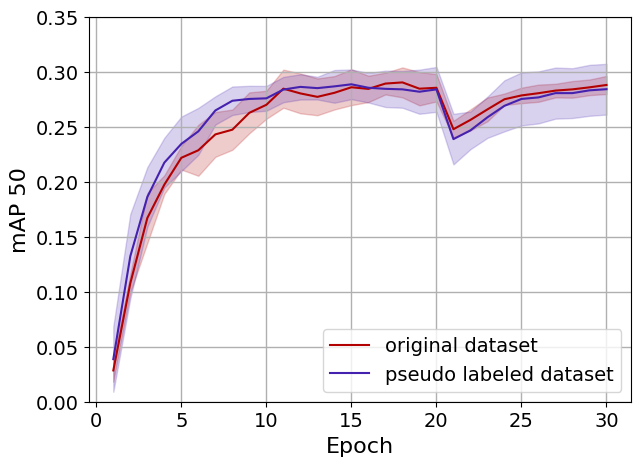

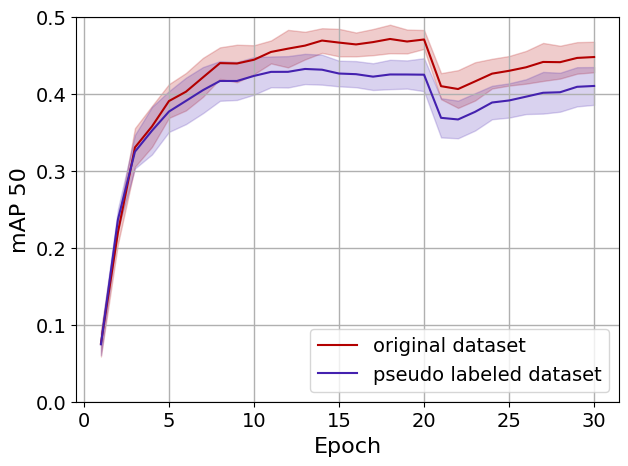

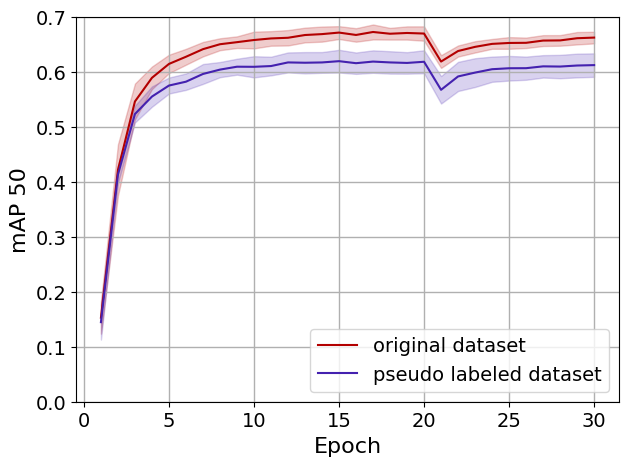

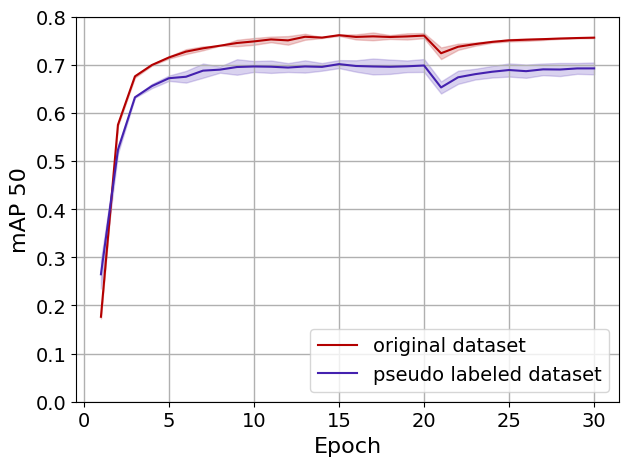

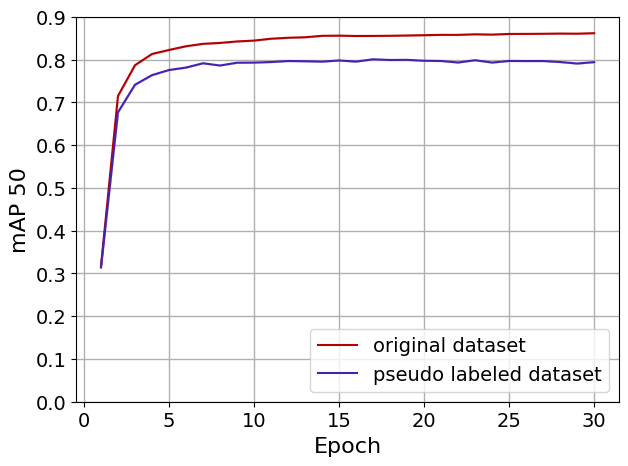

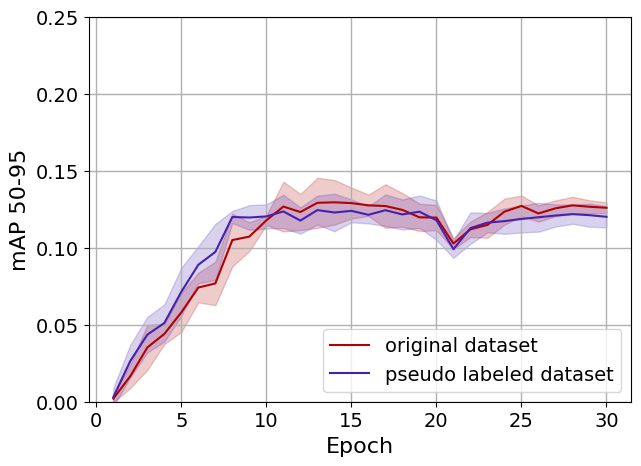

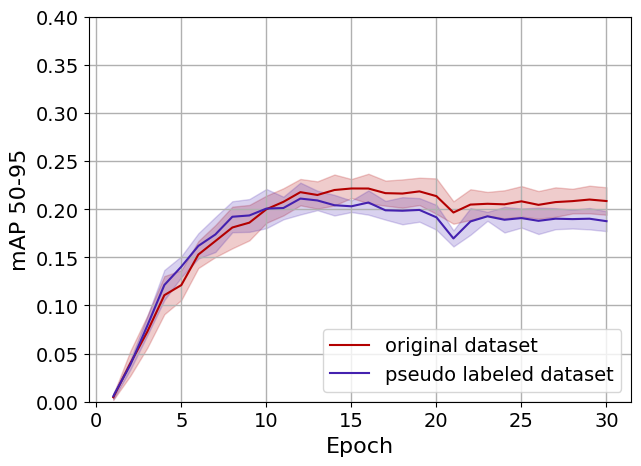

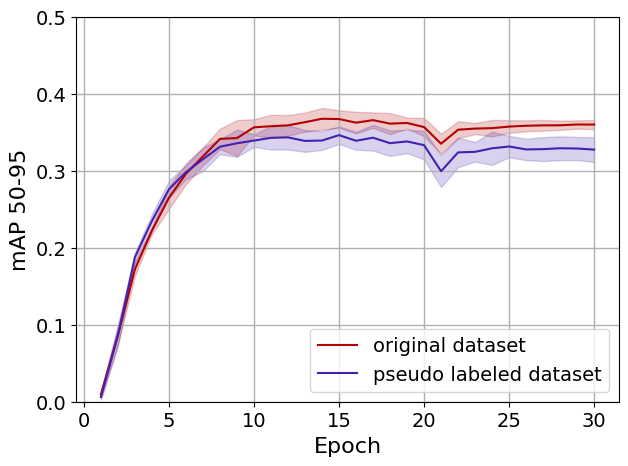

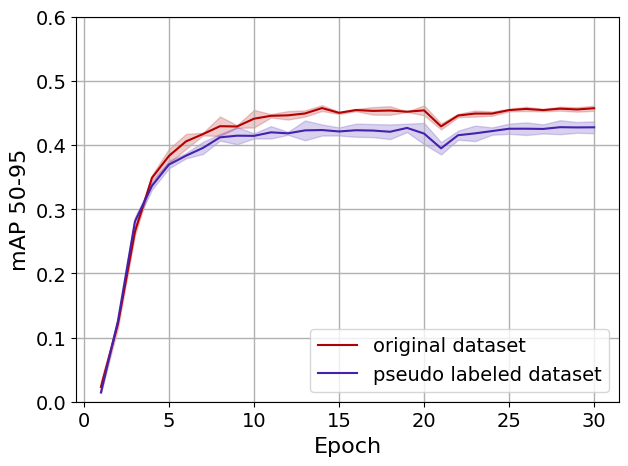

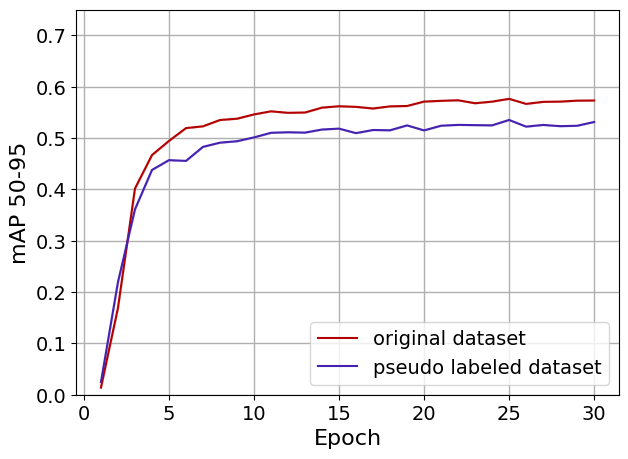

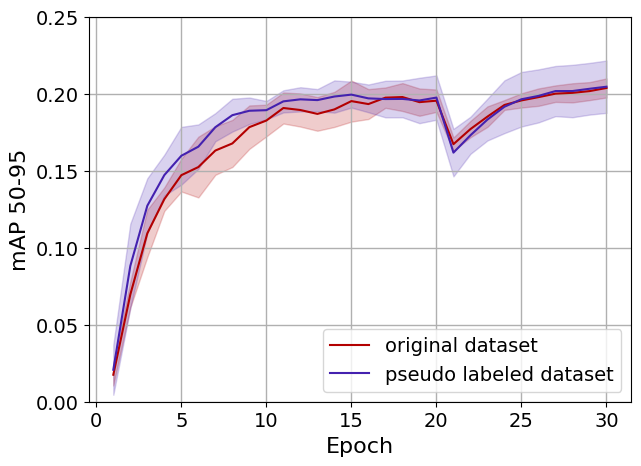

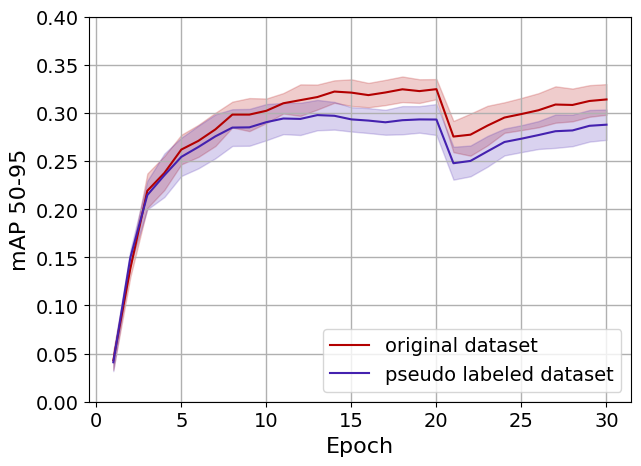

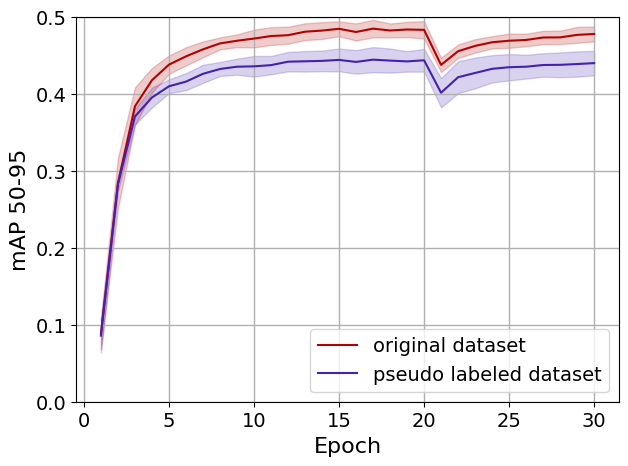

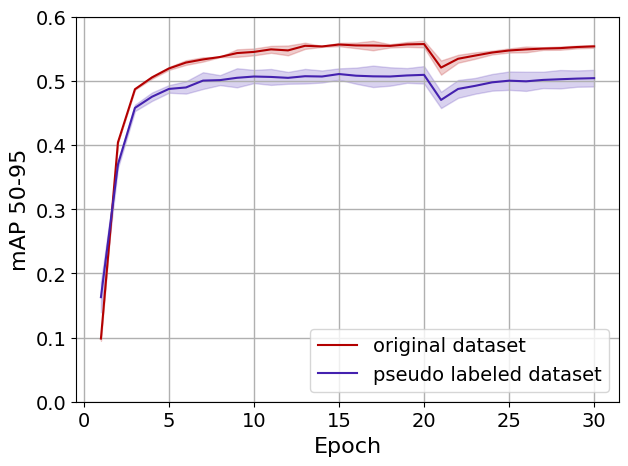

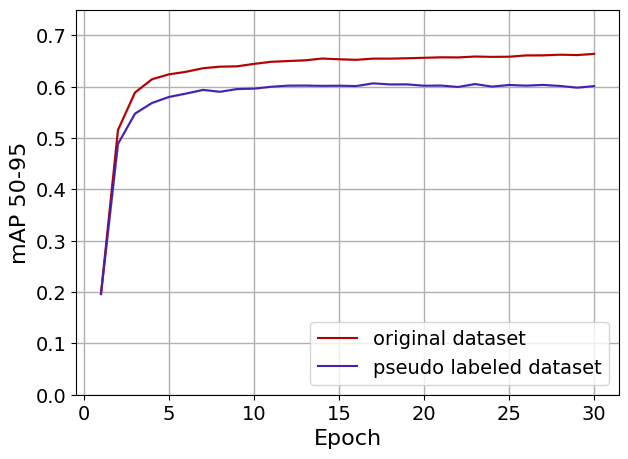

In [139]:
save_dir = 'outputs/partitial_by_epochs_v2'
os.makedirs(save_dir)
dataset_names = ['original dataset', 'pseudo labeled dataset']
datasets = ['orig', 'GD_train_val']
models = ['nano', 'small']
data_volumes = ['100','200','500','1000','2501']
y_lims = [(0,0.35), (0,0.5), (0,0.7), (0,0.8), (0,0.9)]

for model_path, model_name in zip(models, models):
    for d_volume_path, d_volume_name, y_lim in zip(data_volumes, data_volumes, y_lims):
        # data = get_mAP(f'../runs/split_exp/{dataset_path}/{model_path}/{d_volume_path}')
        data1 = get_mean_by_epoch(get_mAP(f'../runs/split_exp/orig/{model_path}/{d_volume_path}'))
        data2 = get_mean_by_epoch(get_mAP(f'../runs/split_exp/GD_train_val/{model_path}/{d_volume_path}'))

        fig, _ = plot_map50_by_epoch(data1, data2, title='', 
            label1='original dataset', label2='pseudo labeled dataset', y_lim=y_lim)
        file_name = f'mAP 50 YOLO {model_name} model trained on {d_volume_name} objects.png'
        print(file_name)
        fig.savefig(f'{save_dir}/{file_name}')

y_lims = [(0,0.25), (0,0.4), (0,0.5), (0,0.6), (0,0.75)]

for model_path, model_name in zip(models, models):
    for d_volume_path, d_volume_name, y_lim in zip(data_volumes, data_volumes, y_lims):
        # data = get_mAP(f'../runs/split_exp/{dataset_path}/{model_path}/{d_volume_path}')
        data1 = get_mean_by_epoch(get_mAP(f'../runs/split_exp/orig/{model_path}/{d_volume_path}'))
        data2 = get_mean_by_epoch(get_mAP(f'../runs/split_exp/GD_train_val/{model_path}/{d_volume_path}'))

        fig, _ = plot_map5095_by_epoch(data1, data2, title='', 
            label1='original dataset', label2='pseudo labeled dataset', y_lim=y_lim)
        file_name = f'mAP 50-95 YOLO {model_name} model trained on {d_volume_name} objects.png'
        print(file_name)
        fig.savefig(f'{save_dir}/{file_name}')

## max mAP by data

In [26]:
def get_all_best_mAP(path, data_training_types, models, training_volumes ):

    results = []
    for dt_type in data_training_types:
        results.append([])
        for model in models:
            results[-1].append([])
            for t_volume in training_volumes:
                results[-1][-1].append(get_best_mAP(f'{path}/{dt_type}/{model}/{t_volume}'))

    results = np.array(results)
    # [2, 2, 5, 4] - [data_training_types, models, training_volumes, map50(mean, std)/map5095(mean, std)]
    return(results)

def get_best_mAP(path):
    exps = os.listdir(path)
    exps = [x for x in exps if re.match('^exp_\d$', x) is not None]
    exps = sorted(exps, key=lambda x: int(re.findall('\d+',x)[0]))
    results =[]
    if len(exps)>0:
        for exp in exps:
            full_path = f'{path}/{exp}/test_best/results.pickle'
            data = pickle.load(open(full_path, "rb"))
            res = (data.map50, data.map)
            results.append(res) # [exp, (map50, map95)] - [N_exp, 2]
    else:
        full_path = f'{path}/test/results.pickle'
        data = pickle.load(open(full_path, "rb"))
        res = (data.map50, data.map)
        results.append(res) # [exp, (map50, map95)] - [N_exp, 2]

    results = np.array(results)
    map50 = results[:,0].mean(axis=0)
    std50 = results[:,0].std(axis=0)
    map5095 = results[:,1].mean(axis=0)
    std5095 = results[:,1].std(axis=0)


    return np.array((map50, std50, map5095, std5095)) #[4]


In [10]:
def plot_best_mAP(training_volumes,data, color, y_label, label, ax):
    ax.scatter(training_volumes, data[:,0],
        s=100, marker='o', color=color)
    ax.plot(training_volumes, data[:,0], color=color, linewidth=2,label=label)
    ax.fill_between(training_volumes,data[:,0] - data[:,1],
                     data[:,0] + data[:,1],alpha=0.2, color=color)

    ax.grid(True)
    # ax.legend(fontsize=15,loc='lower center', borderaxespad=-7)
    ax.legend(fontsize=15,loc='lower right')

    # Увеличение размера подписей и величин на осях
    ax.set_xlabel("Volume of training data", fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
        

In [11]:
def get_best_mAP_train(path):
    exps = os.listdir(path)
    exps = [x for x in exps if re.match('^exp_\d$', x) is not None]
    exps = sorted(exps, key=lambda x: int(re.findall('\d+',x)[0]))
    results =[]
    if len(exps)>0:
        for exp in exps:
            full_path = f'{path}/{exp}/train/results.csv'
            data = prepare_df(full_path)
            res = ([data['metrics/mAP50(B)'].values.max(), data['metrics/mAP50-95(B)'].values.max()])
            results.append(res) # [exp, (map50, map95)] - [N_exp, 2]
    else:
        full_path = f'{path}/train/results.csv'
        data = prepare_df(full_path)
        res = ([data['metrics/mAP50(B)'].values.max(), data['metrics/mAP50-95(B)'].values.max()])
        results.append(res) # [exp, (map50, map95)] - [N_exp, 2]

    results = np.array(results)
    map50 = results[:,0].mean(axis=0)
    std50 = results[:,0].std(axis=0)
    map5095 = results[:,1].mean(axis=0)
    std5095 = results[:,1].std(axis=0)


    return np.array((map50, std50, map5095, std5095)) #[4]

### Pascal VOC

In [ ]:
# !ls ../runs/split_exp/orig/nano/100
save_dir = 'outputs/max_map'
os.makedirs(save_dir, exist_ok=True)

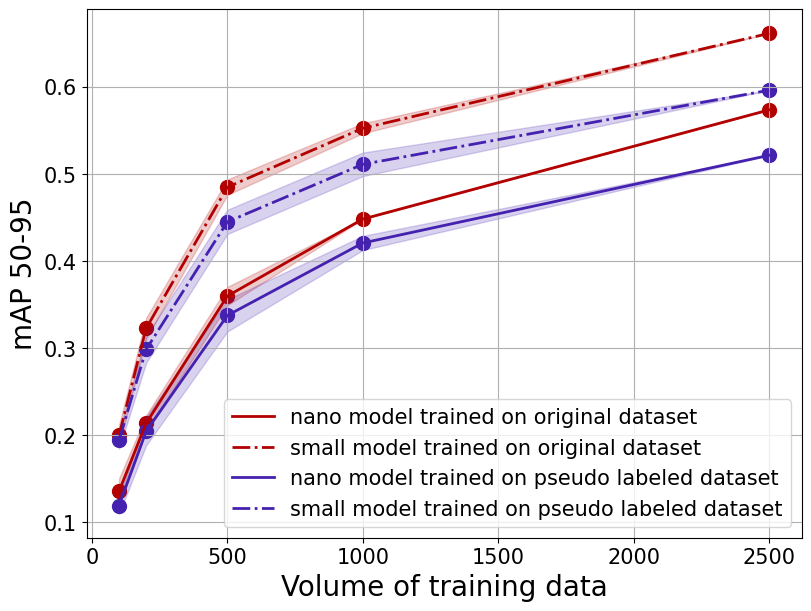

In [18]:
results = get_all_best_mAP()


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                        sharex=True, sharey=True, layout="constrained")
training_volumes = [100,200,500,1000, 2501]
markers = ['o']*len(training_volumes)


colors = [
        "#b30000",
        "#4421af"
    ]
line_type = ['-', '-.']


data_training_types = ['original dataset', 'pseudo labeled dataset']
models = ['nano', 'small']

for dt_type, index_data in zip(data_training_types,[0,1]):
    for model_name, model_index in zip(models, [0,1]):
        axs.scatter(training_volumes, results[index_data, model_index,:,2],
          s=100, marker='o', color=colors[index_data])
        axs.plot(training_volumes, results[index_data, model_index,:,2],
          color=colors[index_data], linewidth=2, linestyle=line_type[model_index],
          label=f'{model_name} model trained on {dt_type}'
          )
        axs.fill_between(training_volumes,
          results[index_data, model_index,:,2] - results[index_data, model_index,:,3],
          results[index_data, model_index,:,2] + results[index_data, model_index,:,3],
          alpha=0.2, color=colors[index_data])


# axs.set_xlim(0, parametrs[-1]*1.1)
# axs.set_ylim(0.7, 0.95)
axs.grid(True)
# axs.legend(fontsize=15,loc='lower center', borderaxespad=-11)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Volume of training data", fontsize=20)
axs.set_ylabel("mAP 50-95", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

file_name = f'mAP 50-95 YOLO models.png'
fig.savefig(f'{save_dir}/{file_name}')

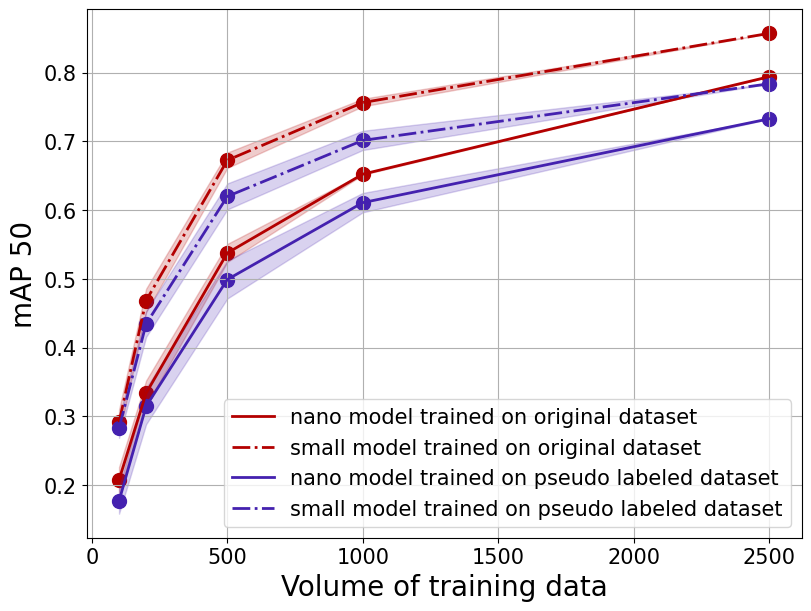

In [17]:
results = get_all_best_mAP()


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                        sharex=True, sharey=True, layout="constrained")
training_volumes = [100,200,500,1000, 2501]
markers = ['o']*len(training_volumes)


colors = [
        "#b30000",
        "#4421af"
    ]
line_type = ['-', '-.']


data_training_types = ['original dataset', 'pseudo labeled dataset']
models = ['nano', 'small']

for dt_type, index_data in zip(data_training_types,[0,1]):
    for model_name, model_index in zip(models, [0,1]):
        axs.scatter(training_volumes, results[index_data, model_index,:,0],
          s=100, marker='o', color=colors[index_data])
        axs.plot(training_volumes, results[index_data, model_index,:,0],
          color=colors[index_data], linewidth=2, linestyle=line_type[model_index],
          label=f'{model_name} model trained on {dt_type}'
          )
        axs.fill_between(training_volumes,
          results[index_data, model_index,:,0] - results[index_data, model_index,:,1],
          results[index_data, model_index,:,0] + results[index_data, model_index,:,1],
          alpha=0.2, color=colors[index_data])


# axs.set_xlim(0, parametrs[-1]*1.1)
# axs.set_ylim(0.7, 0.95)
axs.grid(True)
# axs.legend(fontsize=15,loc='lower center', borderaxespad=-11)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Volume of training data", fontsize=20)
axs.set_ylabel("mAP 50", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

file_name = f'mAP 50 YOLO models.png'
fig.savefig(f'{save_dir}/{file_name}')




mAP50 YOLO nano model.png
mAP50 YOLO small model.png
mAP50-95 YOLO nano model.png
mAP50-95 YOLO small model.png


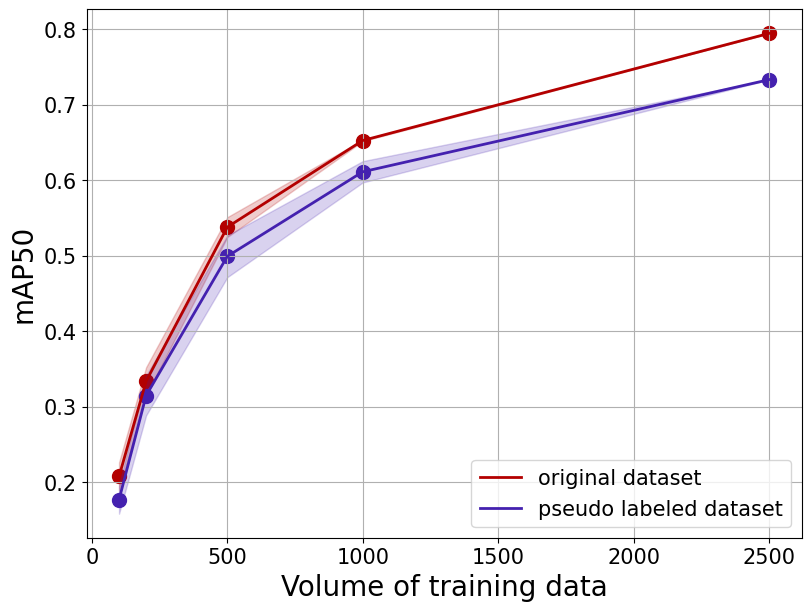

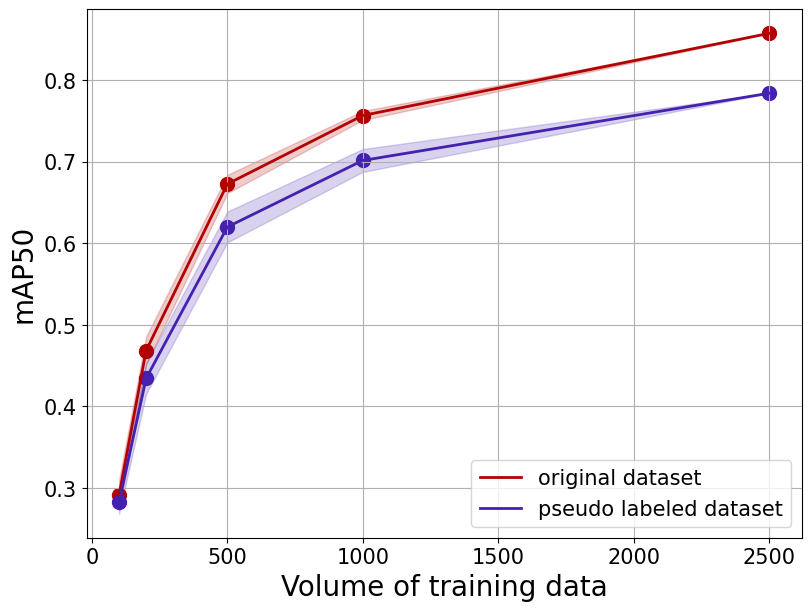

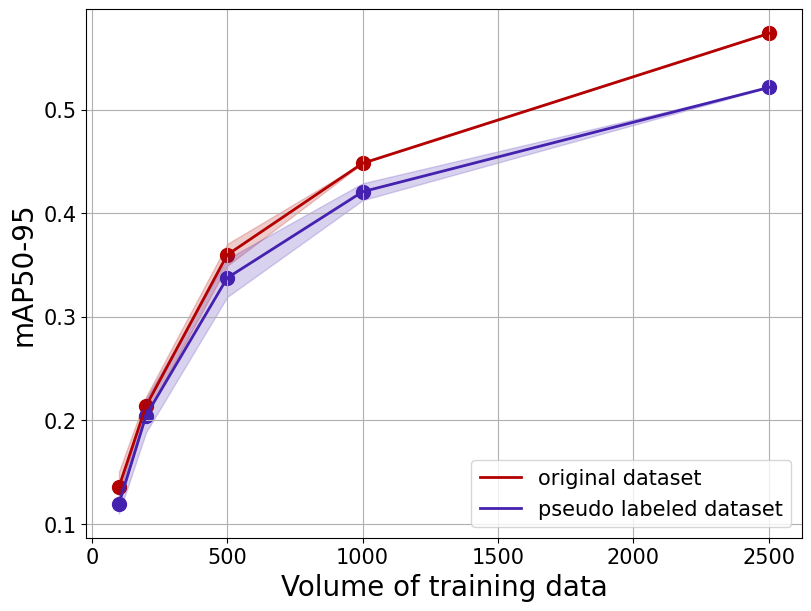

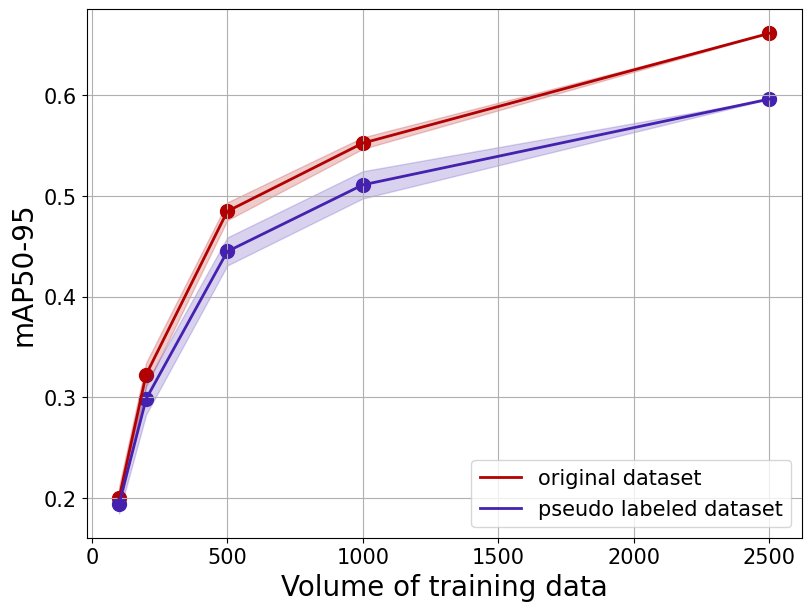

In [12]:
save_dir = 'outputs/max_map'
os.makedirs(save_dir, exist_ok=True)

results = get_all_best_mAP()
training_volumes = [100,200,500,1000, 2501]

colors = [
        "#b30000",
        "#4421af"
    ]

data_training_types = ['original dataset', 'pseudo labeled dataset']
models = ['nano', 'small']
metric_names = ['mAP50', 'mAP50-95']
metric_indexes = [(0,2), (2,4)]

for m_name, m_index in zip(metric_names,metric_indexes):
    for model_name, model_index in zip(models, [0,1]):

        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                        sharex=True, sharey=True, layout="constrained")

        data_orig = results[0, model_index,:,m_index[0]:m_index[1]]
        data_pseudo = results[1, model_index,:,m_index[0]:m_index[1]]
        
        plot_best_mAP(training_volumes,data_orig, color=colors[0], y_label=m_name,
                       label=data_training_types[0], ax=axs)
        plot_best_mAP(training_volumes,data_pseudo, color=colors[1], y_label=m_name,
                       label=data_training_types[1], ax=axs)
        


        file_name = f'{m_name} YOLO {model_name} model.png'
        print(file_name)
        fig.savefig(f'{save_dir}/{file_name}')


In [31]:
save_dir = 'outputs/max_map'

models = ['nano', 'small']
models_path = ['nano', 'small']

dataset_names = ['original dataset', 'pseudo labeled dataset']
dataset_paths = ['orig', 'GD_train_val']

metric_names = ['mAP 50', 'mAP 50-95']
metric_atrs = ['map50','map']

training_volumes = ['100','200','500','1000', '2501']


columns = [f'{d_name} {map_metric}' for d_name in dataset_names for map_metric in metric_names ]
indexes = [f'{model} {t_volume}'  for model in models for t_volume in training_volumes]

df = pd.DataFrame(
    columns=columns,
    index=indexes
)

for model, model_path in zip(models, models_path):
    for d_path, d_name in zip(dataset_paths, dataset_names):
            for t_volume in training_volumes:
            

                path = f'../runs/split_exp/{d_path}/{model_path}/{t_volume}'
                res = get_best_mAP_train(path).round(3)
                map50_string = f'{res[0]}{chr(177)}{res[1]}'
                map5095_string = f'{res[2]}{chr(177)}{res[3]}'
                df.loc[f'{model} {t_volume}', f'{d_name} {metric_names[0]}'] = map50_string
                df.loc[f'{model} {t_volume}', f'{d_name} {metric_names[1]}'] = map5095_string
                

df.to_csv(f'{save_dir}/data.csv')
df

,original dataset mAP 50,original dataset mAP 50-95,pseudo labeled dataset mAP 50,pseudo labeled dataset mAP 50-95
nano 100,0.212±0.014,0.139±0.008,0.196±0.014,0.131±0.008
nano 200,0.345±0.023,0.225±0.014,0.33±0.021,0.216±0.013
nano 500,0.551±0.013,0.372±0.01,0.516±0.02,0.351±0.012
nano 1000,0.668±0.0,0.462±0.0,0.619±0.012,0.429±0.009
nano 2501,0.798±0.0,0.578±0.0,0.743±0.0,0.535±0.0
small 100,0.301±0.011,0.207±0.005,0.298±0.014,0.21±0.012
small 200,0.475±0.015,0.327±0.011,0.436±0.02,0.301±0.015
small 500,0.674±0.013,0.487±0.01,0.625±0.019,0.449±0.014
small 1000,0.765±0.002,0.561±0.002,0.703±0.01,0.513±0.011
small 2501,0.862±0.0,0.665±0.0,0.801±0.0,0.607±0.0


### Vehicle

In [36]:
def get_all_best_mAP_train(path, data_training_types, models, training_volumes ):

    results = []
    for dt_type in data_training_types:
        results.append([])
        for model in models:
            results[-1].append([])
            for t_volume in training_volumes:
                results[-1][-1].append(get_best_mAP_train(f'{path}/{dt_type}/{model}/{t_volume}'))

    results = np.array(results)
    # [2, 2, 5, 4] - [data_training_types, models, training_volumes, map50(mean, std)/map5095(mean, std)]
    return(results)

In [32]:
# !ls ../runs/split_exp/orig/nano/100
save_dir = 'outputs/Vehicle/max_map'
os.makedirs(save_dir, exist_ok=True)

source_path = '../runs/split_exp_vehicle'
data_training_types = ['orig','GD_train']
models = ['nano']
training_volumes = ['100','200','500','1000', '2000', '3500']

In [46]:
source_path = '../runs/split_exp_vehicle'
data_training_types = ['orig','GD_train']
models = ['nano']
training_volumes = ['100','200','500','1000', '2000', '3500']
metric_names = ['mAP 50', 'mAP 50-95']
metric_atrs = ['map50','map']
models_path = models
dataset_paths = ['orig', 'GD_train']

columns = [f'{d_name} {map_metric}' for d_name in dataset_names for map_metric in metric_names ]
indexes = [f'{model} {t_volume}'  for model in models for t_volume in training_volumes]

df = pd.DataFrame(
    columns=columns,
    index=indexes
)



for model, model_path in zip(models, models_path):
    for d_path, d_name in zip(dataset_paths, dataset_names):
            for t_volume in training_volumes:
            

                path = f'{source_path}/{d_path}/{model_path}/{t_volume}'
                res = get_best_mAP_train(path).round(3)
                map50_string = f'{res[0]}{chr(177)}{res[1]}'
                map5095_string = f'{res[2]}{chr(177)}{res[3]}'
                df.loc[f'{model} {t_volume}', f'{d_name} {metric_names[0]}'] = map50_string
                df.loc[f'{model} {t_volume}', f'{d_name} {metric_names[1]}'] = map5095_string
                

df.to_csv(f'{save_dir}/data.csv')
df

,original dataset mAP 50,original dataset mAP 50-95,pseudo labeled dataset mAP 50,pseudo labeled dataset mAP 50-95
nano 100,0.693±0.025,0.459±0.018,0.575±0.021,0.353±0.016
nano 200,0.721±0.015,0.456±0.011,0.58±0.013,0.339±0.014
nano 500,0.795±0.01,0.508±0.006,0.619±0.015,0.36±0.011
nano 1000,0.838±0.018,0.55±0.007,0.65±0.009,0.387±0.007
nano 2000,0.876±0.0,0.576±0.0,0.665±0.0,0.4±0.0
nano 3500,0.887±0.0,0.601±0.0,0.67±0.0,0.397±0.0


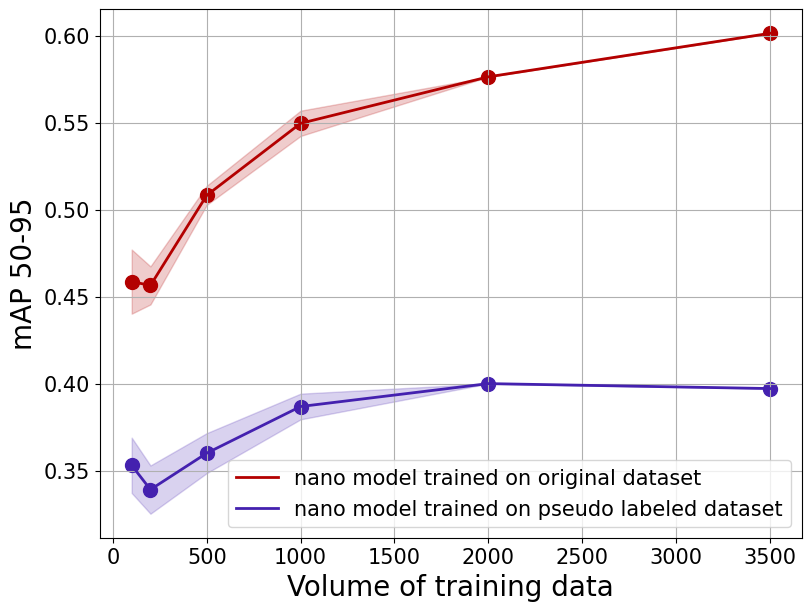

In [52]:


source_path = '../runs/split_exp_vehicle'
data_training_types = ['orig','GD_train']
models = ['nano']
training_volumes = ['100','200','500','1000', '2000', '3500']

results = get_all_best_mAP_train(source_path, data_training_types, models, training_volumes)

training_volumes = [100,200,500,1000, 2000, 3500]
markers = ['o']*len(training_volumes)






fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                        sharex=True, sharey=True, layout="constrained")



colors = [
        "#b30000",
        "#4421af"
    ]
line_type = ['-', '-.']


data_training_types = ['original dataset', 'pseudo labeled dataset']
models = ['nano']

for dt_type, index_data in zip(data_training_types,[0,1]):
    for model_name, model_index in zip(models, [0,1]):
        axs.scatter(training_volumes, results[index_data, model_index,:,2],
          s=100, marker='o', color=colors[index_data])
        axs.plot(training_volumes, results[index_data, model_index,:,2],
          color=colors[index_data], linewidth=2, linestyle=line_type[model_index],
          label=f'{model_name} model trained on {dt_type}'
          )
        axs.fill_between(training_volumes,
          results[index_data, model_index,:,2] - results[index_data, model_index,:,3],
          results[index_data, model_index,:,2] + results[index_data, model_index,:,3],
          alpha=0.2, color=colors[index_data])


# axs.set_xlim(0, parametrs[-1]*1.1)
# axs.set_ylim(0.7, 0.95)
axs.grid(True)
# axs.legend(fontsize=15,loc='lower center', borderaxespad=-11)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Volume of training data", fontsize=20)
axs.set_ylabel("mAP 50-95", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

file_name = f'mAP 50-95 YOLO models.png'
fig.savefig(f'{save_dir}/{file_name}')

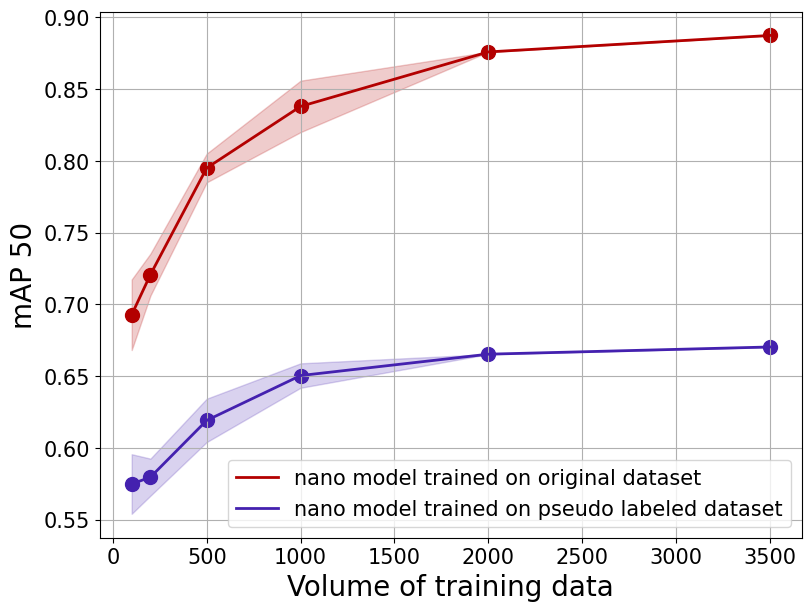

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                        sharex=True, sharey=True, layout="constrained")
training_volumes = [100,200,500,1000, 2000, 3500]


colors = [
        "#b30000",
        "#4421af"
    ]
line_type = ['-', '-.']


data_training_types = ['original dataset', 'pseudo labeled dataset']
models = ['nano']

for dt_type, index_data in zip(data_training_types,[0,1]):
    for model_name, model_index in zip(models, [0,1]):
        axs.scatter(training_volumes, results[index_data, model_index,:,0],
          s=100, marker='o', color=colors[index_data])
        axs.plot(training_volumes, results[index_data, model_index,:,0],
          color=colors[index_data], linewidth=2, linestyle=line_type[model_index],
          label=f'{model_name} model trained on {dt_type}'
          )
        axs.fill_between(training_volumes,
          results[index_data, model_index,:,0] - results[index_data, model_index,:,1],
          results[index_data, model_index,:,0] + results[index_data, model_index,:,1],
          alpha=0.2, color=colors[index_data])


# axs.set_xlim(0, parametrs[-1]*1.1)
# axs.set_ylim(0.7, 0.95)
axs.grid(True)
# axs.legend(fontsize=15,loc='lower center', borderaxespad=-11)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Volume of training data", fontsize=20)
axs.set_ylabel("mAP 50", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

file_name = f'mAP 50 YOLO models.png'
fig.savefig(f'{save_dir}/{file_name}')

In [38]:
results.shape

(2, 1, 6, 4)

In [39]:
training_volumes

[100, 200, 500, 1000, 2501]

In [21]:
!ls ../runs/split_exp/orig/nano/100/exp_1

train
